In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, \
    IDF, StringIndexer
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import re
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import Window
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.sql.utils import AnalysisException
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1618349436462_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sc.install_pypi_package("pandas==0.25.1") 
sc.install_pypi_package("matplotlib==2.2.4") 
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached pandas-0.25.1-cp36-cp36m-manylinux1_x86_64.whl (10.5 MB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)

  Using cached matplotlib-2.2.4-cp36-cp36m-manylinux1_x86_64.whl (12.8 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.3.1-cp36-cp36m-manylinux1_x86_64.whl (1.1 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1
boto                       2.49.0
cycler                     0.10.0
jmespath                   0.9.4
kiwisolver                 1.3.1
lxml                       4.4.2
matplotlib                 2.2.4
mysqlclient                1.4.6
nltk                       3.4.5
nose                       1.3.4
numpy                      1.14.5
pandas                     0.25.1
pip                        21.0.1
py-dateutil                2.2
pyparsing                  2.4.7
python-dateutil        

In [3]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1618349436462_0002,pyspark,idle,Link,Link,✔


In [4]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
import re

In [5]:
# Starter code
from pyspark.sql import SparkSession

# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Read in full sparkify dataset
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
df = spark.read.json(event_data)
print('the data has ', df.count(), ' records')
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

the data has  26259199  records
Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042')

# Intitial Data Cleaning

In [6]:
def data_preclean(input_df):
    """
    initial data cleaning such as convert variable format.
    """
    # cleanse stringtype fields from special characters
    for field in input_df.schema.fields:
        if field.dataType==StringType():
            input_df = input_df.withColumn(field.name, F.regexp_replace(field.name, '[^a-zA-Z0-9\,\-]', ''))
    # create new ts related columns
    input_df = input_df.withColumn('interaction_time', 
                                   F.from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
    input_df = input_df.withColumn('month', F.month(col('interaction_time')))
    input_df = input_df.withColumn('date', F.from_unixtime(col('ts')/1000).cast(DateType()))    
    input_df = input_df.withColumn('userId', col('userId').cast(LongType()))
    # remove user id null
    input_df = input_df.filter(col('userId').isNotNull())
    # filter out log out records
    input_df = input_df.filter(~col('auth').isin(['LoggedOut','Logged Out','Guest']))
    # replace location with extracting state from it
    input_df = input_df.withColumn('state', split(col('location'),',').getItem(1))    
    return input_df

# stack_overflow_data = '..\sample_data\mini_sparkify_event_data.json'
# df = spark.read.json(stack_overflow_data)
df.persist()
print(df.printSchema())
preclean_size = df.count()
df =data_preclean(df)
# df = preclean_transformer.transform(df)
cleaned_size = df.count()
print('pre clean data has {} row and post clean data has {} rows'.format(preclean_size, cleaned_size))
min_date, max_date = df.select(F.min("date"), F.max("date")).first()
print('data range from {} to {} '.format(min_date, max_date))
df.head()

### calculcate some key measures
unique_ids = [i['userId'] for i in df.select('userId').distinct().collect()]
print('there are {} total users in the data with size {}'.format(len(unique_ids), df.count()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

None
pre clean data has 26259199 row and post clean data has 25480720 rows
data range from 2018-10-01 to 2018-12-01 
there are 22277 total users in the data with size 25480720

In [7]:
def has_column(df, col):
    """
    util function that check whether a column is in the data.
    """
    try:
        df[col]
        return True
    except AnalysisException:
        return False
    
def target_labelling(input_df):
    """
    create the target column
    """
    window = Window.partitionBy(input_df['userId']).orderBy(input_df['ts'].desc())
    label_df =\
        input_df.select('userId', 'page', 'auth',F.row_number().over(window).alias('rank')) \
            .filter(col('rank') <= 1)
    label_df = label_df.withColumn('label',
                                   F.when((col('page').isin(['CancellationConfirmation','Cancel']))
                                        |(col('auth')=='Cancelled'),1).otherwise(0))
    label_df = label_df.select('userId','label')
    if has_column(input_df, 'label'):
        input_df = input_df.drop('label')
    input_df = input_df.join(label_df, on='userId',how='left')
    return input_df
df = target_labelling(df)


print('quality check: pre labelling data size', df.count())
df = target_labelling(df)
df.head()
print('quality check: post labelling data size', df.count())
# print(df.count())


def moving_window_features(input_df):
    """
    create features that based on moving time windows.
    """
    input_df = input_df.withColumn('time_since_register',
                        ((col('ts')-col('registration'))/86400000).cast(IntegerType()))
    sessionStarts = input_df.orderBy(['userID','sessionId','ts'],ascending=True).\
                        groupby(['userID','sessionId']).\
                        agg(F.first('ts').alias('sessionStart'))
    sessionStarts.orderBy(['userID','sessionStart'], ascending=True)
    windowval = (Window.partitionBy('userID').orderBy('sessionStart')
             .rangeBetween(Window.unboundedPreceding, 0))
    sessionStarts = sessionStarts.withColumn('session_count',F.count('sessionId').over(windowval))
    input_df = input_df.join(sessionStarts,on=['userID','sessionId'])
    return input_df

df = moving_window_features(df)
df.head()
print('quality check: post moving window data size', df.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

quality check: pre labelling data size 25480720
quality check: post labelling data size 25480720
quality check: post moving window data size 25480720

In [8]:
# %%local

window = Window.partitionBy(df['userId']).orderBy(df['ts'])
status_df = df.groupBy('status').count().orderBy('count', ascending=False)
status_df.persist()
status_df.count()

window = Window.partitionBy(df['userId']).orderBy(df['ts'].desc())
user_final_status =\
    df.select('userId', 'page', 'auth','date','ts','label', 'state', 'level', 'method', F.row_number().over(window).alias('rank')) \
        .filter(col('rank') <= 1)
user_final_status.persist()
print('quality check: user final status shape:', user_final_status.count())

user_final_status.count()
window = Window.partitionBy(df['userId']).orderBy(df['ts'])
user_first_status =\
    df.select('userId', 'page', 'auth','date','ts','label', 'state', 'level', 'method',  F.row_number().over(window).alias('rank')) \
        .filter(col('rank') <= 1)
user_first_status.persist()
user_first_status.count()

page_types = df.groupBy('page').count().orderBy('count', ascending=False)
page_types.persist()
page_types.count()

location_activities = df.groupBy('state').count().orderBy('count', ascending=False)
location_activities.persist()
location_activities.count()

level_count_activities = df.groupBy('level').count().orderBy('count', ascending=False)
level_count_activities.persist()
level_count_activities.count()

method_count_activities = df.groupBy('method').count().orderBy('count', ascending=False)
method_count_activities.persist()
method_count_activities.count()

window = Window.partitionBy(df['userId']).orderBy(df['ts'].desc())
user_final_status_check =\
    df.select('userId', 'page', 'auth','date','ts','label',  'state', 'level', 'method', F.row_number().over(window).alias('rank')) \
        .filter(col('rank') <= 1)
user_final_status_check.persist()
user_final_status_check.count()

ts_from_register_df = df.filter(col('page').isin(['CancellationConfirmation','Cancel'])).select('time_since_register')
ts_from_register_df.persist()
ts_from_register_df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

quality check: user final status shape: 22277
10006

In [9]:
%%spark -o level_count_activities

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
%%spark -o location_activities

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
%%spark -o user_final_status -n 50000

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
%%spark -o ts_from_register_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
%%spark -o user_first_status -n 50000

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
%%spark -o method_count_activities

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
%%spark -o status_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Data Analysis

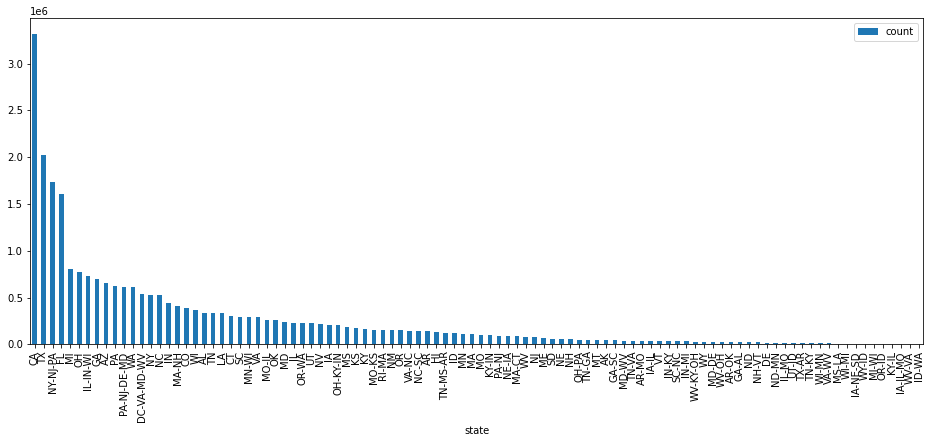

In [16]:
%%local
fig, ax = plt.subplots(figsize=(16,6))
location_activities.set_index('state').plot(ax=ax,kind='bar')

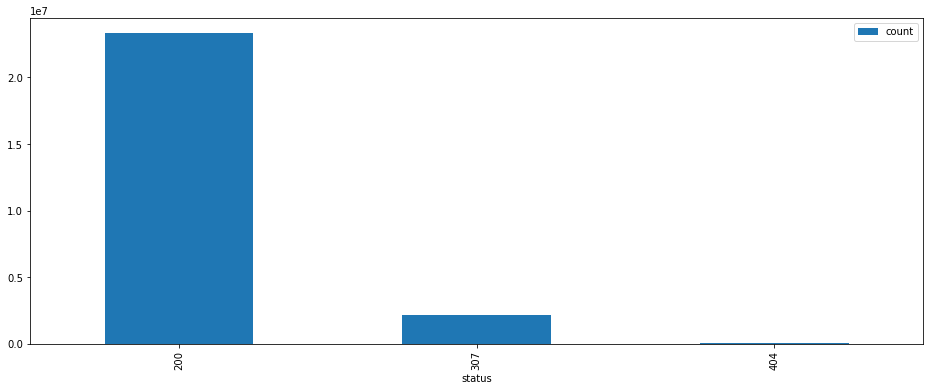

In [17]:
%%local
fig, ax = plt.subplots(figsize=(16,6))
status_df.set_index('status').plot(ax=ax,kind='bar')

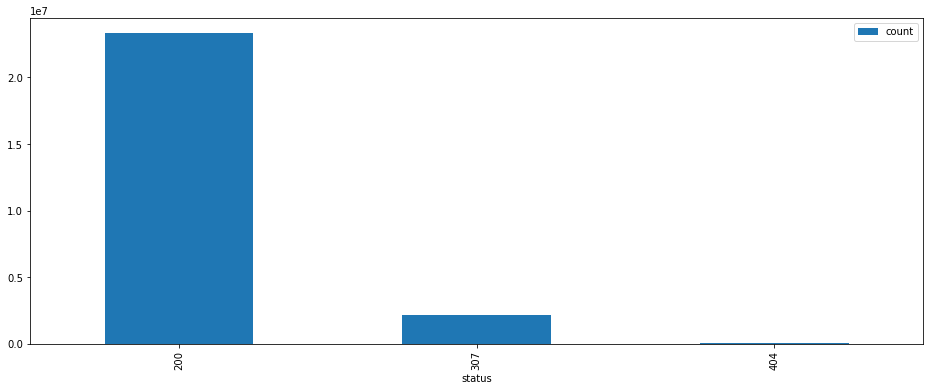

In [18]:
%%local
# print(type(level_count_activities))
fig, ax = plt.subplots(figsize=(16,6))
status_df.set_index('status').plot(ax=ax,kind='bar')

(22277, 10)


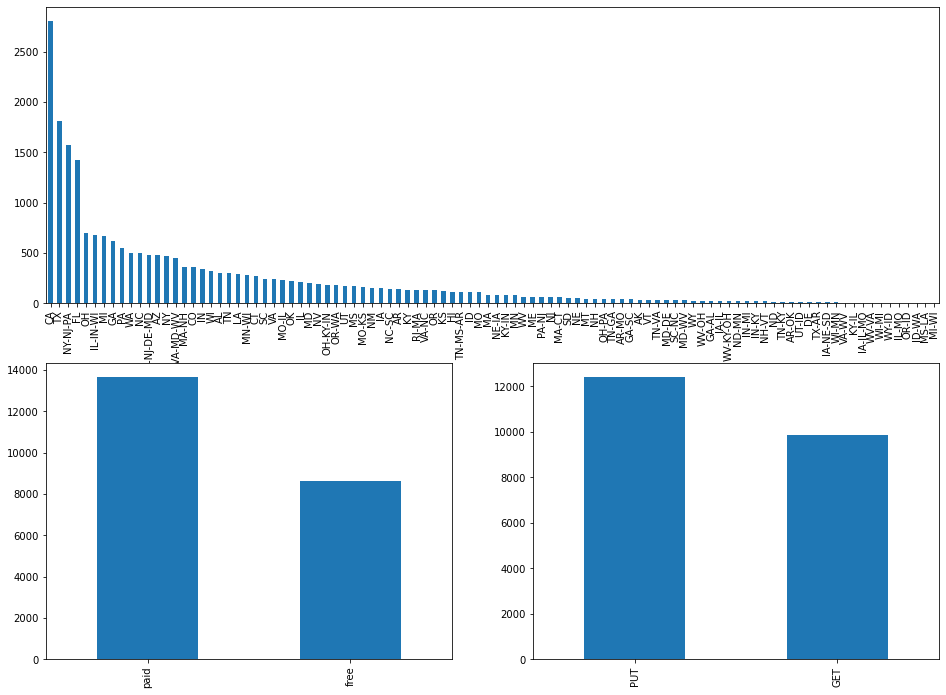

In [19]:
%%local
# we first example the status of the users. 
fig, ax = plt.subplots(2,2, figsize=(16,12))
print(user_final_status.shape)
ax = plt.subplot(2, 1, 1)
# df = df.withColumn('state', split(col('location'),',').getItem(1))    
location = user_final_status['state'].value_counts()
location.plot(ax=ax,kind='bar')
    
ax = plt.subplot(2, 2, 3)
level_count = user_final_status['level'].value_counts()
# level_count = df.groupBy('level').count().orderBy('count', ascending=False).toPandas()
level_count.plot( ax=ax,kind='bar')
    
ax = plt.subplot(2, 2, 4)
method_count = user_final_status['method'].value_counts()
method_count.plot( ax=ax,kind='bar')
# method_count = df.groupBy('method').count().orderBy('count', ascending=False).toPandas()
# method_count.set_index('method').plot(ax=ax, kind='bar')


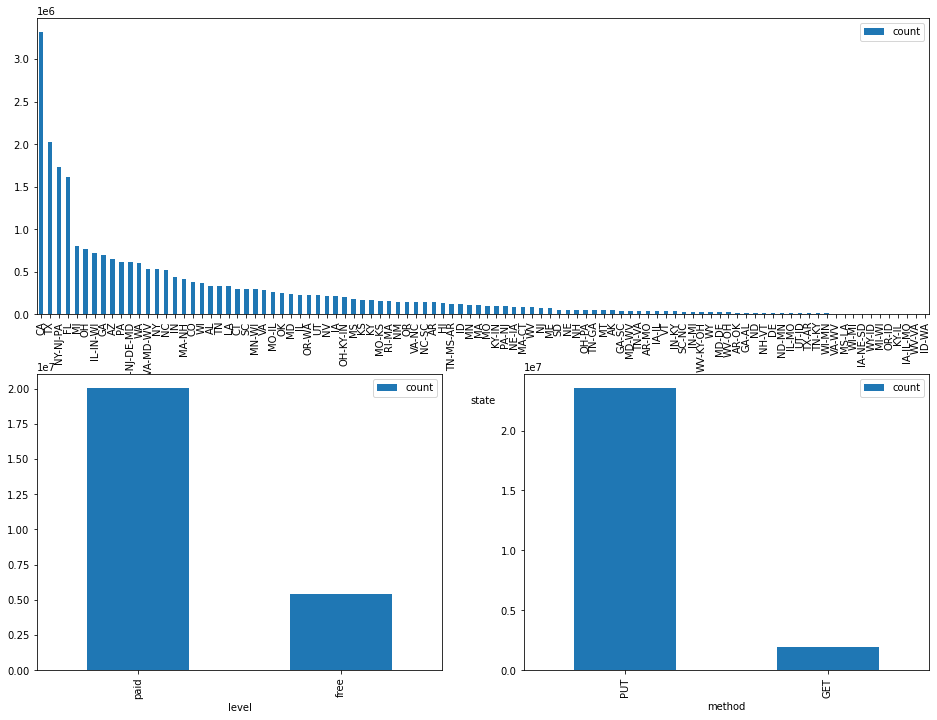

In [20]:
%%local
# we first example the status of the users. 
fig, ax = plt.subplots(2,2, figsize=(16,12))

ax = plt.subplot(2, 1, 1)
location_activities.set_index('state').plot(ax=ax,kind='bar')
    
ax = plt.subplot(2, 2, 3)
level_count_activities.set_index('level').plot( ax=ax,kind='bar')
    
ax = plt.subplot(2, 2, 4)
method_count_activities.set_index('method').plot(ax=ax, kind='bar')


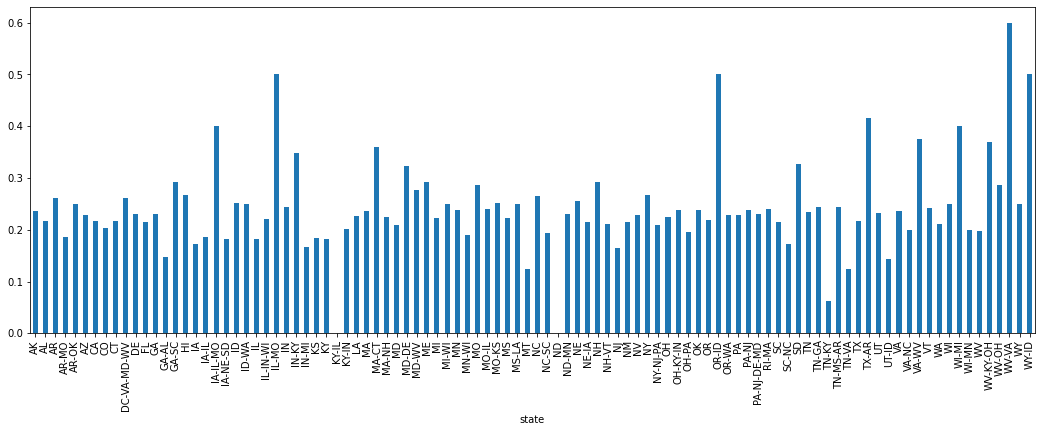

In [21]:
%%local
# from pyspark.sql import functions as F
location = user_final_status.groupby(['state'])['label'].mean()
location.plot(figsize=(18,6), kind='bar')

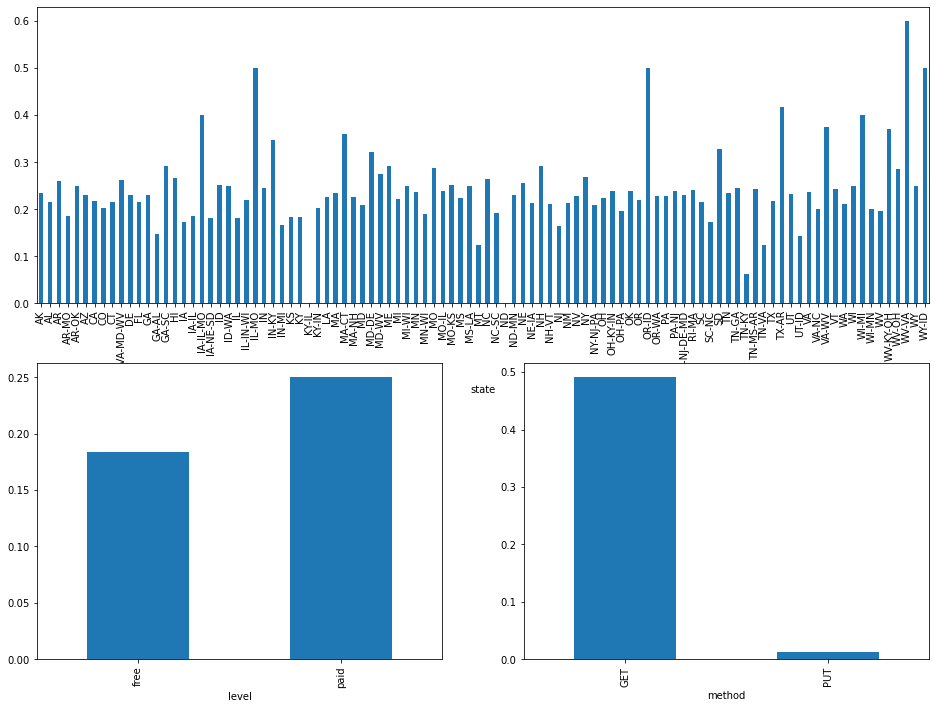

In [22]:
%%local
# we first example the status of the users. 
fig, ax = plt.subplots(2,2, figsize=(16,12))

ax = plt.subplot(2, 1, 1)
# df = df.withColumn('state', split(col('location'),',').getItem(1))    
location = user_final_status.groupby(['state'])['label'].mean()
location.plot(ax=ax,kind='bar')

ax = plt.subplot(2, 2, 3)
level_count = user_final_status.groupby(['level'])['label'].mean()
# level_count = df.groupBy('level').count().orderBy('count', ascending=False).toPandas()
level_count.plot( ax=ax,kind='bar')

ax = plt.subplot(2, 2, 4)
method_count = user_final_status.groupby(['method'])['label'].mean()
method_count.plot( ax=ax,kind='bar')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f030dbc3610>]],
      dtype=object)

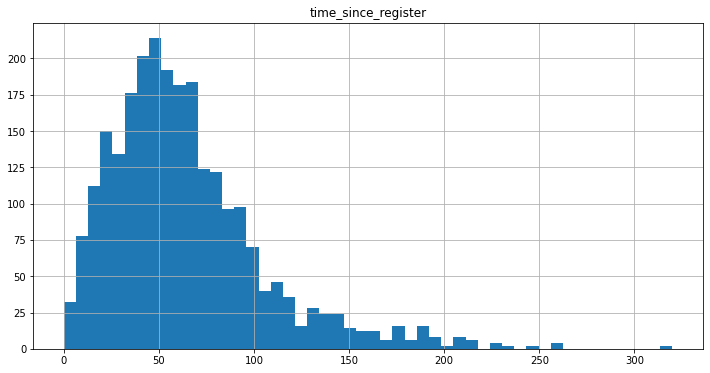

In [23]:
%%local
ts_from_register_df.hist(figsize=(12,6),bins=50)

In [16]:
def generate_training_data(features_df):
    """
    Transforms features with feature pipeline
    :param features_df: Spark DataFrame of features
    :return Spark Dataframe with label and assembled features
    """
    num_cols = []
    
    for field in features_df.schema.fields :
        if field.dataType!=StringType():
            num_cols.append(field.name)

#     num_cols.remove('label')
#     num_cols.remove('interaction_time')
    num_cols = [item for item in num_cols if item not in ['label','ts', 'interaction_time', 'status', 'sessionId',
                                                          'sessionStart' ,'registration', 'date','userId']]
#     print(num_cols)
    indexer_gender = StringIndexer(inputCol='gender', outputCol='gender_index').setHandleInvalid("skip")
    indexer_location = StringIndexer(inputCol='state', outputCol='state_index').setHandleInvalid("skip")
#     indexer_valid_level = StringIndexer(inputCol='valid_level', outputCol='valid_level_index')
    print(num_cols+['gender_index', 'state_index'])
    assembler = VectorAssembler(inputCols=num_cols+['gender_index', 'state_index'], 
                                outputCol='features').setHandleInvalid("skip")

    process_pipeline = Pipeline(stages=[indexer_gender, indexer_location,  assembler])
#     process_pipeline = build_pipeline(num_cols)
    model_df = process_pipeline.fit(features_df).transform(features_df)
#     return model_df.select("label", "features")
    return model_df

model_df = generate_training_data(df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['itemInSession', 'length', 'month', 'time_since_register', 'session_count', 'gender_index', 'state_index']

In [17]:
num_cols_refer = ['itemInSession', 'length', 'month', 'time_since_register', 'session_count', 'gender_index', 'state_index']
model_df.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in num_cols_refer]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+------+-----+-------------------+-------------+------------+-----------+
|itemInSession|length|month|time_since_register|session_count|gender_index|state_index|
+-------------+------+-----+-------------------+-------------+------------+-----------+
|            0|     0|    0|                  0|            0|           0|          0|
+-------------+------+-----+-------------------+-------------+------------+-----------+

In [18]:
num_cols_refer = ['itemInSession', 'length', 'month', 'time_since_register', 'session_count', 'gender_index', 'state_index']
model_df.select(num_cols_refer).summary().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+
|summary|     itemInSession|            length|             month|time_since_register|     session_count|       gender_index|       state_index|
+-------+------------------+------------------+------------------+-------------------+------------------+-------------------+------------------+
|  count|          20850272|          20850272|          20850272|           20850272|          20850272|           20850272|          20850272|
|   mean|108.80280070207237|248.72543296748236|10.467762914555744|  65.46200908074485|14.777150820862193|0.47801692946739494|  15.8365029482589|
| stddev| 118.5943588886103| 97.28710387078065|0.4989597961604559| 41.189882292546656|14.243521438584956|0.49951652282685605|18.055886300274974|
|    min|                 0|             0.522|                10|                -22|                 1|                0.0|     

## Model Fitting

In [19]:
train, test = model_df.randomSplit([0.9, 0.1], seed=42)
print('training size:', train.count(), 'testing size:', test.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

training size: 18766587 testing size: 2083685

In [20]:
train.select(['itemInSession', 'length', 'month', 'time_since_register', 'session_count', 'gender_index', 'state_index','features']).summary().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+
|summary|     itemInSession|            length|              month|time_since_register|     session_count|      gender_index|       state_index|
+-------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+
|  count|          18766587|          18766587|           18766587|           18766587|          18766587|          18766587|          18766587|
|   mean|108.81494583964574|248.73089264521656| 10.467700440149294|  65.45734677275095|14.775978125377833|0.4780509636621726|15.837787073376742|
| stddev|118.60467085517071| 97.29279219806591|0.49895576785102164| 41.187104719767625|14.244899901513412|0.4995180207957654|18.055979211667168|
|    min|                 0|             0.522|                 10|                -22|                 1|               0.0|     

In [21]:
train.select(['itemInSession', 'length', 'month', 'time_since_register', 'session_count', 'gender_index', 'state_index','features']).printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- time_since_register: integer (nullable = true)
 |-- session_count: long (nullable = false)
 |-- gender_index: double (nullable = false)
 |-- state_index: double (nullable = false)
 |-- features: vector (nullable = true)

In [22]:
# train, test = model_df.randomSplit([0.9, 0.1], seed=42)
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline = Pipeline(stages=[lr])

paramsGrid = ParamGridBuilder()\
                .addGrid(lr.regParam,[0.0,0.1])\
                .addGrid(lr.maxIter,[10,50])\
                .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramsGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

cvModel = crossval.fit(train)
cvModel.avgMetrics

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.5863832937913819, 0.6781666752052863, 0.6099203349840403, 0.6733599411817255]

In [33]:
predictions = cvModel.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

VBox()

Exception in thread cell_monitor-23:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 604



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-24:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 628



Test Area Under ROC: 0.6782670971304879

In [34]:
predictions = cvModel.transform(train)
evaluator = BinaryClassificationEvaluator()
print("Train Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-25:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 655



Train Area Under ROC: 0.6781691247427435

In [29]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, maxBins=128)
pipeline = Pipeline(stages=[rf])

paramsGrid = ParamGridBuilder()\
                .addGrid(rf.numTrees,[100])\
                .build()
rfModel = rf.fit(train)
# crossval2 = CrossValidator(estimator=pipeline,
#                           estimatorParamMaps=paramsGrid,
#                           evaluator=BinaryClassificationEvaluator(),
#                           numFolds=3)

# cvModel2 = crossval2.fit(train)
# cvModel2.avgMetrics

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-20:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 538



In [30]:
predictions = rfModel.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-21:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 571



Test Area Under ROC: 0.6807443165646874

In [31]:
predictions = rfModel.transform(train)
evaluator = BinaryClassificationEvaluator()
print("Train Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-22:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 586



Train Area Under ROC: 0.6805640527774823

In [32]:
print(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1